# CNN_3channel_Center

Abstract:
- Center
- CNN, small net

Result:
- Kaggle score: 

References:
- https://www.kaggle.com/ivalmian/simple-svd-xgboost-baseline-lb-35
- https://www.kaggle.com/arieltci/a-keras-prototype-0-21174-on-pl
- https://www.kaggle.com/henokanh/cnn-batchnormalization-0-1646

## 1. Preprocess

### Import pkgs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import log_loss, accuracy_score
from IPython.display import display

%matplotlib inline

In [2]:
import os
import time
import zipfile
import lzma
import pickle
from PIL import Image
from shutil import copy2

### Run name

In [3]:
project_name = 'SC_Iceberg_Classifier'
step_name = 'CNN_3channel_Center'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)

run_name: SC_Iceberg_Classifier_CNN_3channel_Center_20180103_224418


### Basic folders

In [4]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)

input_path: D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\input
log_path: D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\log
model_path: D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\model
output_path: D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\output


### Load data

In [5]:
sample_submission_path = os.path.join(input_path, 'sample_submission.csv')
sample_submission = pd.read_csv(sample_submission_path)
print(sample_submission.shape)
sample_submission.head(2)

(8424, 2)


,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.5


In [6]:
is_iceberg_path = os.path.join(input_path, 'is_iceberg.p')

y_data = pickle.load(open(is_iceberg_path, mode='rb'))

print(y_data.shape)

(1604,)


In [7]:
%%time
#Load orignal data
inc_angle_data_path = os.path.join(input_path, 'inc_angle_data.p')
inc_angle_test_path = os.path.join(input_path, 'inc_angle_test.p')

inc_angle_data = pickle.load(open(inc_angle_data_path, mode='rb'))
inc_angle_test = pickle.load(open(inc_angle_test_path, mode='rb'))

print(inc_angle_data.shape)
print(inc_angle_test.shape)

(1604,)
(8424,)
Wall time: 2 ms


In [8]:
%%time
#Load orignal data
band1_data_path = os.path.join(input_path, 'band1_data_center.p')
band2_data_path = os.path.join(input_path, 'band2_data_center.p')
band1_test_path = os.path.join(input_path, 'band1_test_center.p')
band2_test_path = os.path.join(input_path, 'band2_test_center.p')

band1_data = pickle.load(open(band1_data_path, mode='rb'))
band2_data = pickle.load(open(band2_data_path, mode='rb'))
band1_test = pickle.load(open(band1_test_path, mode='rb'))
band2_test = pickle.load(open(band2_test_path, mode='rb'))

print(band1_data.shape)
print(band2_data.shape)
print(band1_test.shape)
print(band2_test.shape)

(1604, 39, 39)
(1604, 39, 39)
(8424, 39, 39)
(8424, 39, 39)
Wall time: 307 ms


In [9]:
%%time
x_data = np.concatenate([band1_data[:, :, :, np.newaxis],
                         band2_data[:, :, :, np.newaxis]], axis=-1)
print(x_data.shape)
x_test = np.concatenate([band1_test[:, :, :, np.newaxis],
                         band2_test[:, :, :, np.newaxis]], axis=-1)
print(x_test.shape)

(1604, 39, 39, 2)
(8424, 39, 39, 2)
Wall time: 182 ms


In [10]:
%%time
x_train, x_val, inc_angle_train, inc_angle_val, y_train, y_val = train_test_split(x_data, inc_angle_data, y_data, test_size=0.15, shuffle=True, random_state=31)
print(x_train.shape)
print(x_val.shape)
print(inc_angle_train.shape)
print(inc_angle_val.shape)
print(y_train.shape)
print(y_val.shape)

(1363, 39, 39, 2)
(241, 39, 39, 2)
(1363,)
(241,)
(1363,)
(241,)
Wall time: 33.5 ms


## 2. Build model

In [11]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization, Input
from keras.layers.merge import Concatenate
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

Using TensorFlow backend.


In [12]:
def build_model():
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu',
                     input_shape = (39, 39, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(strides=(2,2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(strides=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units = 1, activation = 'sigmoid'))

    model.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [13]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 37, 37, 32)        608       
_________________________________________________________________
batch_normalization_1 (Batch (None, 37, 37, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 35, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 35, 35, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

In [14]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
saveModel(model, 'saveModel_test')

In [15]:
def get_lr(x):
    lr = round(1e-4 * 0.98 ** x, 6)
    if lr < 5e-5:
        lr = 5e-5
    print(lr, end='  ')
    return lr

# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
annealer = LearningRateScheduler(get_lr)

log_dir = os.path.join(log_path, run_name)
print('log_dir:' + log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)

log_dir:D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\log\SC_Iceberg_Classifier_CNN_3channel_Center_20180103_224418


In [16]:
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=[0.001, 0.1],
#     channel_shift_range=0.1,
#     horizontal_flip=False,
#     vertical_flip=False)

In [17]:
%%time
hist = model.fit(x_train, y_train, 
                 batch_size = 128, 
                 verbose= 1,
                 epochs = 50, #1 for ETA, 0 for silent
                 validation_data=(x_val, y_val),
                 callbacks=[annealer, tensorBoard])

Train on 1363 samples, validate on 241 samples
0.0001  Epoch 1/50
1363/1363 [==============================] - 7s 5ms/step - loss: 1.5130 - acc: 0.5048 - val_loss: 0.6936 - val_acc: 0.4440
9.8e-05  Epoch 2/50
1363/1363 [==============================] - 4s 3ms/step - loss: 1.1313 - acc: 0.5451 - val_loss: 0.6929 - val_acc: 0.5394
9.6e-05  Epoch 3/50
1363/1363 [==============================] - 4s 3ms/step - loss: 0.9554 - acc: 0.5598 - val_loss: 0.6927 - val_acc: 0.5602
9.4e-05  Epoch 4/50
1363/1363 [==============================] - 4s 3ms/step - loss: 0.8611 - acc: 0.5965 - val_loss: 0.6913 - val_acc: 0.5602
9.2e-05  Epoch 5/50
1363/1363 [==============================] - 4s 3ms/step - loss: 0.8406 - acc: 0.5745 - val_loss: 0.6896 - val_acc: 0.5726
9e-05  Epoch 6/50
1363/1363 [==============================] - 4s 3ms/step - loss: 0.8167 - acc: 0.5701 - val_loss: 0.6884 - val_acc: 0.5934
8.9e-05  Epoch 7/50
1363/1363 [==============================] - 4s 3ms/step - loss: 0.7608 - acc:

In [18]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

241/241 [==============================] - 0s 2ms/step
Final loss: 0.5624, final accuracy: 0.6763


In [19]:
val_prob1 = model.predict(x_val)

# print('Val log_loss: {}'.format(log_loss(y_val, val_prob1)))
val_prob1_limit = np.clip(val_prob1, 0.00005, 0.99995)
loss = log_loss(y_val, val_prob1_limit)
print('Val log_loss: {}'.format(loss))

val_prob1_limit = np.clip(val_prob1_limit, 0.05, 0.95)
loss = log_loss(y_val, val_prob1_limit)
print('Val log_loss: {}'.format(loss))

Val log_loss: 0.5624153085856765
Val log_loss: 0.5633293169075275


In [20]:
final_acc_str = str(int(loss*10000))
run_name_acc = project_name + '_' + step_name + '_' + time_str + '_' + final_acc_str
print(run_name_acc)

SC_Iceberg_Classifier_CNN_3channel_Center_20180103_224418_5633


In [21]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


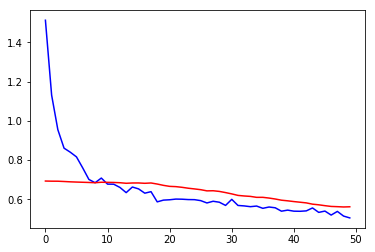

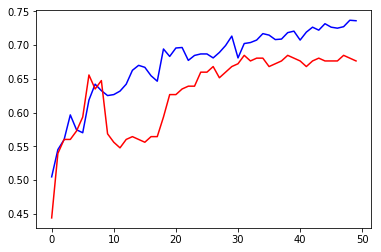

In [22]:
plt.plot(histories['loss'], color='b')
plt.plot(histories['val_loss'], color='r')
plt.show()
plt.plot(histories['acc'], color='b')
plt.plot(histories['val_acc'], color='r')
plt.show()

In [23]:
saveModel(model, run_name_acc)

## 3. Predict

In [24]:
if not os.path.exists(output_path):
    os.mkdir(output_path)
pred_file = os.path.join(output_path, run_name_acc + '.csv')
print(pred_file)

D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\output\SC_Iceberg_Classifier_CNN_3channel_Center_20180103_224418_5633.csv


In [25]:
test_prob = model.predict(x_test)
print(test_prob.shape)
print(test_prob[0:2])
test_prob = np.clip(test_prob, 0.05, 0.95)
print(test_prob.shape)
print(test_prob[0:2])

(8424, 1)
[[ 0.54849112]
 [ 0.52519292]]
(8424, 1)
[[ 0.54849112]
 [ 0.52519292]]


In [26]:
sample_submission['is_iceberg'] = test_prob
print(sample_submission[0:2])
print(sample_submission.shape)
sample_submission.to_csv(pred_file, index=False)

         id  is_iceberg
0  5941774d    0.548491
1  4023181e    0.525193
(8424, 2)


In [27]:
print(run_name_acc)
print('Done!')

SC_Iceberg_Classifier_CNN_3channel_Center_20180103_224418_5633
Done!
